# Load features and targets

In [1]:
# load features
import pickle
features = pickle.load( open( "Onehotfeatures.pkl", "rb" ) )

# load associated targets
from numpy import load
y = load('target.npy')

Choose features and prepare data for scikit-learn prototyping

In [2]:
# keep features of interest
imp_feature = ['User_ID', 'Product_ID', 'Gender_Prod_cat123']
# imp_feature = ['User_ID', 'Product_ID', 'Gender', 'Prod_cat123']
# only keep corresponding features
X_features = tuple(f[0] for f in features if f[1] in imp_feature)

In [3]:
from scipy.sparse import hstack
X = hstack( X_features )
X.shape, type(X)

((550071, 9996), scipy.sparse.coo.coo_matrix)

# Random forest

### Random forest - Grid search (Takes too long on my machine, think days)

On top of decision tree hyperparameters, Random forest adds the following hyperparameters:
1. **n_estimators**, number of trees in forest
2. **bootstrap**, adds extra randomness (sample data with replacement)

[Sklearn Random Forest Regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) 

Define parameter grid

In [ ]:
# DEFINE PARAMETERS VALUES FOR GRID SEARCH
import numpy as np

depth_arr = np.array([ 10**x for x in range(2,4+1)])
# depth_arr = np.array([ x for x in range(100,1000+100, 100)])

min_leaf_arr = np.array([ x+1 for x in range(0, 100+10, 10)])
min_leaf_arr[0]=1
# min_leaf_arr = np.array([ x for x in range(0, 20+1, 1)])
# min_leaf_arr = min_leaf_arr[1:]

est_arr = np.array([ 200, 500, 3000, 5000 ])

param_grid_rfr = [{'max_depth': depth_arr, 'min_samples_leaf': min_leaf_arr, 'n_estimators': est_arr}]
param_grid_rfr

Run grid search

In [ ]:
# Random forest are bags of decision trees, running this grid will take DAYS on a quad-core i7!
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=10,\
                            min_samples_leaf = 5, max_depth = 925,\
                            n_jobs=-1, random_state=29, bootstrap = True, verbose = 1)

# Grid search on max_depth, min_samples_leaf
from sklearn.model_selection import GridSearchCV, ShuffleSplit

# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=1, test_size=1/5, random_state=4)

# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
rfr_grid = GridSearchCV(rfr, param_grid_rfr, cv=cv, scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 1)

# run grid search, commented out to avoid accidental run
# rfr_grid.fit(X,y)

# Show winning parameters
rfr_grid.best_estimator_
# rfr_grid.best_params_
# rfr_grid.cv_results_

Cross-validation best results

In [ ]:
# best score is the lowest MSE (averaged over Kfold cross-validation for each parameter value)
print( 'MSE, best param, mean cross-val = {:.4f}'.format(-rfr_grid.best_score_) )
print( 'RMSE, best param, mean cross-val = {:.4f}'.format(np.sqrt(-rfr_grid.best_score_)) )

Performance on entire training set

In [ ]:
# get predictions from rfr_grid, grid search refit rfr_grid on entire training set using best params
y_pred_grid = rfr_grid.predict(X)
# plot metrics on training set and compare to cross-validation metrics
from sklearn.metrics import mean_squared_error
print('MSE (whole training set) = {:.4f}'.format(mean_squared_error(y, y_pred_grid)))
print('RMSE (whole training set) = {:.4f}'.format(np.sqrt(mean_squared_error(y, y_pred_grid))))

### Random Forest - Single model

Each tree is build on as many samples as the original training set (cannot change that setting
unless you use Bagging class in sklearn).<br>

Each tree is build by splitting node randomly. It ensures each tree is different (cannot change that setting unless you use Bagging class then decision tree default is 'best' for node spiltting) <br>

The equivalent random forest can be achieved with bagging class:
```Python
from sklearn.ensemble import BaggingRegressor
rfr = BaggingRegressor(
                DecisionTreeRegressor(spiltter='random', min_samples_leaf = 5, max_depth = 900)
                n_estimators = 10, max_samples = 1.0,\
                n_jobs = -1, , bootstrap = True, random_state = 29, verbose = 1)
```

One can enable bootstrap which samples training set with replacement thus adding extra randomness. (Increasing the number of tree is advised in that case)

Create Random forest and cross-validate

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 500,\
                            min_samples_leaf = 5, max_depth = 925,\
                            n_jobs = -1, random_state = 29, bootstrap = True, verbose = 1)

from sklearn.model_selection import cross_validate, ShuffleSplit
# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)

# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
cv_results_forest = cross_validate(rfr, X, y=y, cv=cv, scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 1)

Performance on cross-validation

In [5]:
import numpy as np
print('MSE (mean cross-validation) = {:.4f}'.format(-np.mean(cv_results_forest['test_score'])))
print('RMSE (mean cross-validation) = {:.4f}'.format(np.sqrt(-np.mean(cv_results_forest['test_score']))))
# Last results
# 500 trees => RSME 2633.5295, 8h
# 20 trees => RSME 2635.2640, 20 min 
# 10 trees => RSME 2637

MSE (mean cross-validation) = 6906755.9122
RMSE (mean cross-validation) = 2628.0708


NOTE:<br>
Because bootstrap is True, there will be unused sample for each tree grown. Those are called Out-Of-Bag (OOB).Out-Of-Bag samples only tells you about the performance of each tree on aggregate and not on the entire random forest, it won't be a very good indicator as opposed to a proper cros-validation.

Run on entire training set

In [9]:
# train one decision tree on entire dataset, cross_validate does it on k-1 splits
rfr.fit(X,y)

# metrics on entire dataset, must be higher that Xval scores
y_pred = rfr.predict(X)
from sklearn.metrics import mean_squared_error
print('\nMSE (whole training set) = {:.4f}'.format(mean_squared_error(y, y_pred)))
print('RMSE (whole training set) = {:.4f}'.format(np.sqrt(mean_squared_error(y, y_pred))))

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 80.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 91.4min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    9.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   22.0s



MSE (whole training set) = 6623330.7058
RMSE (whole training set) = 2573.5832


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   25.2s finished


Feature importance is a measure of each feature efficiency of reduction in impurity weighted by the number of samples at each node. It is normalized by the sum of feature importances.

<IPython.core.display.Javascript object>


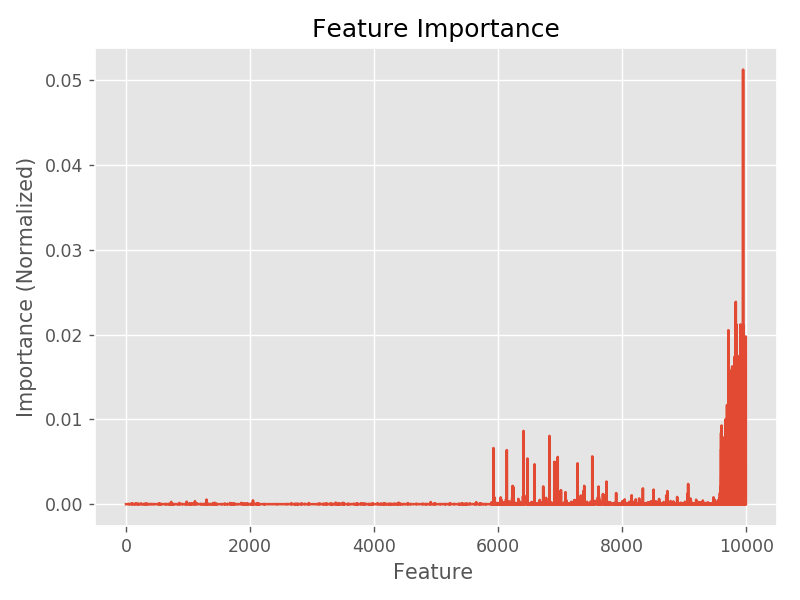

In [10]:
# keep matplotlib interactive
%matplotlib notebook
import matplotlib.pyplot as plt
# use ggplot style
plt.style.use('ggplot')

# feature importance shows Product categories are the best indicator followed by Product ID and user ID (barely)
_, axrf = plt.subplots()
axrf.plot(rfr.feature_importances_)
# add title and axes labels
axrf.set_title('Feature Importance')
axrf.set_xlabel('Feature ')
axrf.set_ylabel('Importance (Normalized)')
plt.tight_layout()

Save model 

In [11]:
# SAVE MODEL
from sklearn.externals import joblib
joblib.dump(rfr, 'RandomForest_Model.pkl')

# # example to load model
# rfr = joblib.load('RandomForest_500_Model.pkl') 

['RandomForest_Model.pkl']

# Run model on test set

Read test set in memory and recover encoders from file and derive one-hot encoded features

In [12]:
from utils import fextract as ft
import pandas as pd
import pickle
import importlib

filename = './test_HujdGe7/test.csv'
df_test = pd.read_csv(filename)

# Load encoders
encoders = pickle.load( open( "Onehotencoders.pkl", "rb" ) )
catcoders = pickle.load( open( "Category_encoders.pkl", "rb" ) )

# reload is necessary if one makes changes in fextract. Indeed modules are loaded once only, this forces a reload.
importlib.reload(ft)

# get one-hot encoded features and their names
features_test = ft.prepare_Data(df_test, (catcoders, encoders))

Select necessary features (must match your feature model obviously)

In [13]:
X_features_test = tuple(f[0] for f in features_test if f[1] in imp_feature)
X_test = hstack( X_features_test )
# check shape
X_test.shape

(233599, 9996)

Make predictions and save them to file

In [14]:
y_pred_test = rfr.predict(X_test)

# format result save to csv for submission
df_results = df_test.loc[:,('User_ID','Product_ID')]
df_results['Purchase'] = y_pred_test.reshape(-1,1)
df_results.to_csv('Submission_RandomForest.csv', index=False)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    9.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   11.0s finished
